##Libraries

In [ ]:
#!pip install tpot
#!pip install pmdarima

In [3]:
import numpy as np
import pandas as pd
import os
from sklearn.model_selection import train_test_split
from tpot import TPOTClassifier
import matplotlib.pyplot as plt
from pmdarima import auto_arima
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import adfuller
import plotly.graph_objs as go
from statsmodels.tools.eval_measures import rmse
from itertools import product
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.ensemble import GradientBoostingRegressor

import warnings
warnings.filterwarnings('ignore')

## Data

In [4]:
#data = pd.read_csv(url, delimiter=',', error_bad_lines=False)
data = pd.read_csv('/content/sample_data/daily crime numbers and weather data for time series analysis.csv')
data.head(1)

,date,Kidnapping/Abduction,"Sex Offenses, Forcible",Robbery,Assault Offenses,Arson,Extortion/Blackmail,Burglary/Breaking & Entering,Larceny/Theft Offenses,Motor Vehicle Theft,...,solarradiation,solarenergy,uvindex,sunrise,sunset,moonphase,conditions,description,icon,stations
0,2010-01-01,0,13,31,58,0,0,77,215,21,...,174.8,15.0,7.0,07:16:59,17:33:24,0.53,Partially cloudy,Clearing in the afternoon.,partly-cloudy-day,"KHOU,72059400188,KIAH,KMCJ,72244012918,7224301..."


## Seasonal Decomposition

This code snippet performs seasonal decomposition on time series data to extract its components, namely trend, seasonality, and residuals.

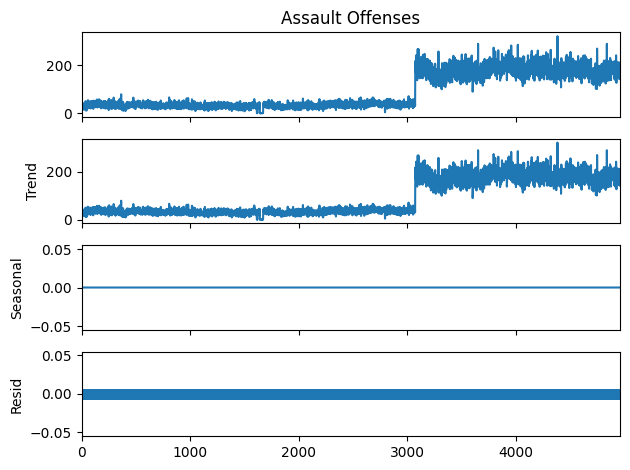

In [42]:
# Convert datetime index to numeric representation
# data_numeric_index = data.reset_index()

# Apply seasonal decomposition
result = seasonal_decompose(data['Assault Offenses'], model='additive' , period=1)  # Assuming no clear seasonal pattern

# Plot the decomposed components
result.plot()
plt.show()


## Autocorrelation Function

Autocorrelation measures the relationship between a variable and its lagged values over time. It helps to identify patterns and dependencies within the time series data.

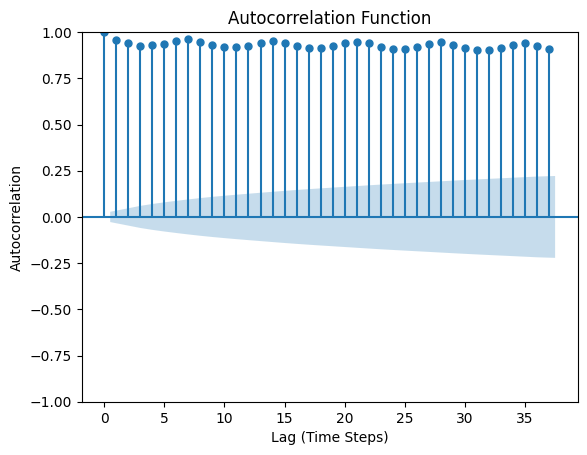

In [43]:

# Specify the column name containing numerical data
column_name = 'Assault Offenses'  # Replace with the actual column name

# Plot the autocorrelation function for the specified column
plot_acf(data[column_name])
plt.xlabel('Lag (Time Steps)')
plt.ylabel('Autocorrelation')
plt.title('Autocorrelation Function')
plt.show()


## Partial Autocorrelation

Let’s move on to the second type of temporal information that can be present in time series data: autocorrelation.

Autocorrelation is the correlation between a time series current value with past values. Autocorrelation can be positive or negative.

`Positive autocorrelation` means that a high value now is likely to yield a high value in the future and vice versa.

`Negative autocorrelation` is the opposite: a high value today implies a low value tomorrow and a low-value today implies a high-value tomorrow.

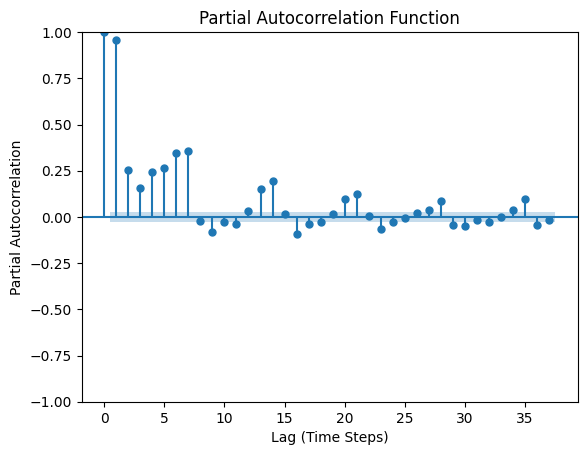

In [44]:
# Specify the column name containing numerical data
column_name = 'Assault Offenses'  # Replace with the actual column name

# Plot the partial autocorrelation function for the specified column
plot_pacf(data[column_name])
plt.xlabel('Lag (Time Steps)')
plt.ylabel('Partial Autocorrelation')
plt.title('Partial Autocorrelation Function')
plt.show()


## Stationarity

A stationary time series is a time series that has no trend.

We can detect non-stationarity using a statistical hypothesis test called `Dickey-Fuller Test` and we can remove non-stationarity using `differencing`.

In [45]:
column_name = 'Assault Offenses'  # Replace with the actual column name

# Ensure data is a 1D array
data_values = data[column_name].values

# Perform the Augmented Dickey-Fuller test
adf, pval, usedlag, nobs, crit_vals, icbest =  adfuller(data_values)
print('ADF test statistic:', adf)
print('ADF p-values:', pval)
print('ADF number of lags used:', usedlag)
print('ADF number of observations:', nobs)
print('ADF critical values:', crit_vals)
print('ADF best information criterion:', icbest)


ADF test statistic: -1.124097323060276
ADF p-values: 0.7053671391540702
ADF number of lags used: 31
ADF number of observations: 4928
ADF critical values: {'1%': -3.43167766021121, '5%': -2.8621266803613676, '10%': -2.5670822909919067}
ADF best information criterion: 40911.818299639795


* ADF Test Statistic: This statistic is used to determine the stationarity of the time series. A more negative value indicates stronger evidence against the null hypothesis of non-stationarity.

* ADF p-value: In this case, the p-value is greater than the commonly used significance level of 0.05, suggesting weak evidence against the null hypothesis.

* Non-stationarity implies that the statistical properties of the time series, such as mean and variance, change over time.

## Differencing

Differencing is a technique used to make a time series stationary by computing the difference between consecutive observations. The purpose of differencing is to remove the underlying trend or seasonality in the data, making it easier to model.

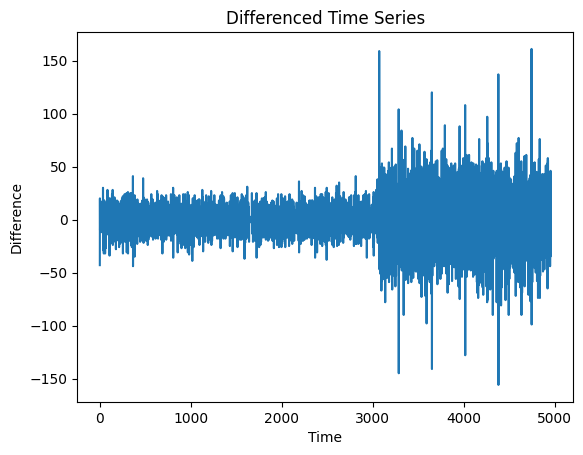

In [46]:
column_name = 'Assault Offenses'  # Replace with the actual column name

# Ensure data is a 1D array
data_values = data[column_name].values

# Compute differenced series
prev_value = data_values[:-1]  # Shifted by one time step
current_value = data_values[1:]  # Current values
differenced = current_value - prev_value

# Plot differenced series
plt.plot(differenced)
plt.xlabel('Time')
plt.ylabel('Difference')
plt.title('Differenced Time Series')
plt.show()


Let's redo the ADF on the differenced data:

In [47]:
# Convert differenced array to pandas Series
differenced_series = pd.Series(differenced.squeeze())

# Perform Augmented Dickey-Fuller test on differenced series
adf_result = adfuller(differenced_series.dropna())
adf = adf_result[0]
pval = adf_result[1]
usedlag = adf_result[2]
nobs = adf_result[3]
crit_vals = adf_result[4]
icbest = adf_result[5]

# Print results
print('ADF test statistic:', adf)
print('ADF p-values:', pval)
print('ADF number of lags used:', usedlag)
print('ADF number of observations:', nobs)
print('ADF critical values:', crit_vals)
print('ADF best information criterion:', icbest)


ADF test statistic: -15.4394764244306
ADF p-values: 2.8777164564891805e-28
ADF number of lags used: 32
ADF number of observations: 4926
ADF critical values: {'1%': -3.431678199534402, '5%': -2.862126918629921, '10%': -2.56708241783182}
ADF best information criterion: 40900.94526718958


The p-value associated with the ADF test statistic is 2.8777164564891805e-28, which is extremely close to zero. A small p-value (typically below 0.05) suggests strong evidence against the null hypothesis (the data is non-stationary). In this case, the very small p-value provides strong evidence to reject the null hypothesis in favor of stationarity.

## Test/Train Split

In [5]:
# Define the date for splitting data into train and test sets
split_date = '2022-01-01'

# Create training and testing datasets
train_data = data[data['date'] < split_date]
test_data = data[data['date'] >= split_date]

# Univariate analysis

## Target variable is '`Assault Offenses`'

In [6]:
target = 'Assault Offenses'

# Extract features (X) and target (y) for training and testing sets
X_train = train_data.drop(columns=['date', target])  # Assuming 'date' is not a feature
y_train = train_data[target]

X_test = test_data.drop(columns=['date', target])
y_test = test_data[target]


# Fit SARIMA model
model = SARIMAX(train_data[target], order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
results = model.fit()

# Make predictions
forecast = results.get_forecast(steps=12)


# Supervised Machine Learning Models

## 1. SARIMA Model

                                     SARIMAX Results                                      
Dep. Variable:                   Assault Offenses   No. Observations:                 4960
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood              -21310.573
Date:                            Mon, 11 Mar 2024   AIC                          42631.145
Time:                                    06:14:34   BIC                          42663.678
Sample:                                         0   HQIC                         42642.554
                                           - 4960                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3116      0.010     30.393      0.000       0.292       0.332
ma.L1         -0.9139      0.004   

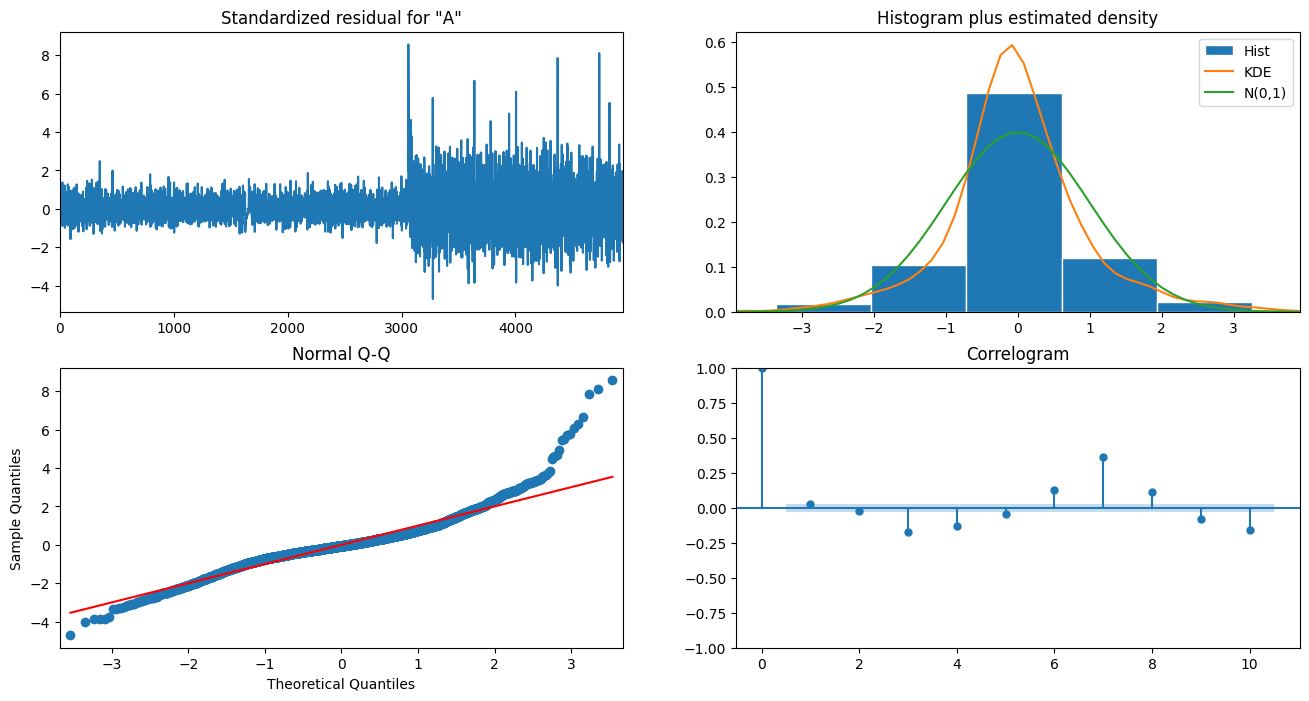

In [58]:
order=(1, 1, 1)
seasonal_order=(1, 1, 1, 12)
sarima_model = SARIMAX(data[target], order=order, seasonal_order=seasonal_order)
sarima_result = sarima_model.fit()

# Print summary of SARIMA model
print(sarima_result.summary())

# Plot diagnostics of SARIMA model
sarima_result.plot_diagnostics(figsize=(16, 8))
plt.show()

# Forecast future values with SARIMA model
forecast = sarima_result.forecast(steps=12)  # number of steps or months to forecast



In [59]:

# Step 2: Visualize the Time Series Data
fig = go.Figure()
fig.add_trace(go.Scatter(x=data.index, y=data['Assault Offenses'], mode='lines', name='Assault Offenses'))
fig.update_layout(title='Assault Offenses Time Series', xaxis_title='Date', yaxis_title='Assault Offenses')
fig.show()

# Step 3: Train-Test Split
train_data = data.iloc[:-12]  # using all data except last 12 months for training
test_data = data.iloc[-12:]  # using last 12 months for testing

# Step 4: Determine SARIMA Parameters
# (Assume parameters are determined based on ACF/PACF plots)

# Step 5: Fit SARIMA Model
order=(1, 1, 1)
seasonal_order=(1, 1, 1, 12)
sarima_model = SARIMAX(train_data['Assault Offenses'], order=order, seasonal_order=seasonal_order)
sarima_result = sarima_model.fit()

# Step 6: Forecast Future Values
forecast = sarima_result.forecast(steps=12)  # Forecasting next 12 months

# Step 7: Model Evaluation
# Calculate RMSE
rmse_score = rmse(test_data['Assault Offenses'], forecast)
print("RMSE:", rmse_score)

# Calculate MSE
mse_score = mean_squared_error(test_data['Assault Offenses'], forecast)
print("MSE:", mse_score)

# Calculate R-squared (R2)
r2 = r2_score(test_data['Assault Offenses'], forecast)
print("R-squared (R2):", r2)

# Calculate Mean Absolute Percentage Error (MAPE)
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
mape = mean_absolute_percentage_error(test_data['Assault Offenses'], forecast)
print("Mean Absolute Percentage Error (MAPE):", mape)

# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(test_data['Assault Offenses'], forecast)
print("Mean Absolute Error (MAE):", mae)

# Plot Actual vs. Forecasted Values
fig = go.Figure()
fig.add_trace(go.Scatter(x=train_data.index, y=train_data['Assault Offenses'], mode='lines', name='Train'))
fig.add_trace(go.Scatter(x=test_data.index, y=test_data['Assault Offenses'], mode='lines', name='Test'))
fig.add_trace(go.Scatter(x=test_data.index, y=forecast, mode='lines', name='Forecast'))
fig.update_layout(title='Assault Offenses Forecast', xaxis_title='Date', yaxis_title='Assault Offenses')
fig.show()


RMSE: 21.39739499457908
MSE: 457.8485125540379
R-squared (R2): 0.08364116017427237
Mean Absolute Percentage Error (MAPE): 10.960897805812737
Mean Absolute Error (MAE): 18.573307582570916


## 2. Arima Model

In [8]:
import pandas as pd
import numpy as np
import plotly.graph_objs as go
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from itertools import product

# Step 2: Visualize the Time Series Data
fig = go.Figure()
fig.add_trace(go.Scatter(x=data.index, y=data['Assault Offenses'], mode='lines', name='Assault Offenses'))
fig.update_layout(title='Assault Offenses Time Series', xaxis_title='Date', yaxis_title='Assault Offenses')
fig.show()

# Step 3: Train-Test Split
train_data = data.iloc[:-12]  # using all data except last 12 months for training
test_data = data.iloc[-12:]  # using last 12 months for testing

# Step 4: Fit ARIMA Model with Best Parameters
order = (1, 1, 1)
arima_model = ARIMA(train_data['Assault Offenses'], order=order)
arima_result = arima_model.fit()

# Step 5: Forecast Future Values
forecast = arima_result.forecast(steps=12)

# Step 6: Model Evaluation
# Calculate RMSE
rmse_score = mean_squared_error(test_data['Assault Offenses'], forecast, squared=False)
print("RMSE:", rmse_score)

# Calculate MSE
mse_score = mean_squared_error(test_data['Assault Offenses'], forecast)
print("MSE:", mse_score)

# Calculate R-squared (R2)
r2 = r2_score(test_data['Assault Offenses'], forecast)
print("R-squared (R2):", r2)

# Calculate Mean Absolute Percentage Error (MAPE)
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
mape = mean_absolute_percentage_error(test_data['Assault Offenses'], forecast)
print("Mean Absolute Percentage Error (MAPE):", mape)

# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(test_data['Assault Offenses'], forecast)
print("Mean Absolute Error (MAE):", mae)

# Plot Actual vs. Forecasted Values
fig = go.Figure()
fig.add_trace(go.Scatter(x=train_data.index, y=train_data['Assault Offenses'], mode='lines', name='Train'))
fig.add_trace(go.Scatter(x=test_data.index, y=test_data['Assault Offenses'], mode='lines', name='Test'))
fig.add_trace(go.Scatter(x=test_data.index, y=forecast, mode='lines', name='Forecast'))
fig.update_layout(title='Assault Offenses Forecast', xaxis_title='Date', yaxis_title='Assault Offenses')
fig.show()


RMSE: 22.282925701120273
MSE: 496.52877780164636
R-squared (R2): 0.006224717804010238
Mean Absolute Percentage Error (MAPE): 11.203396324629798
Mean Absolute Error (MAE): 18.93849089557389


## 3. LSTM (Long Short-Term Memory) Model

In [31]:
import pandas as pd
import numpy as np
import plotly.graph_objs as go
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from keras.models import Sequential
from keras.layers import LSTM, Dense

# Step 1: Importing Data
ts_data = data['Assault Offenses'].values.reshape(-1, 1)  # Reshape to 2D array for scaling

# Step 2: Visualize the Time Series Data
fig = go.Figure()
fig.add_trace(go.Scatter(x=data.index, y=data['Assault Offenses'], mode='lines', name='Assault Offenses'))
fig.update_layout(title='Assault Offenses Time Series', xaxis_title='Date', yaxis_title='Assault Offenses')
fig.show()

# Step 3: Train-Test Split
train_data = ts_data[:-12]  # using all data except last 12 months for training
test_data = ts_data[-12:]  # using last 12 months for testing

# Step 4: Normalize the Data
scaler = MinMaxScaler(feature_range=(0, 1))
train_data_normalized = scaler.fit_transform(train_data)

# Step 5: Prepare the Data for LSTM
def create_dataset(dataset, time_steps=1):
    X, Y = [], []
    for i in range(len(dataset) - time_steps):
        X.append(dataset[i:(i + time_steps), 0])
        Y.append(dataset[i + time_steps, 0])
    return np.array(X), np.array(Y)

time_steps = 12  # number of time steps to look back
X_train, Y_train = create_dataset(train_data_normalized, time_steps)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

# Step 6: Build the LSTM Model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(LSTM(units=50))
model.add(Dense(units=1))

# Step 7: Compile the Model
model.compile(optimizer='adam', loss='mean_squared_error')

# Step 8: Train the Model
model.fit(X_train, Y_train, epochs=10, batch_size=32)

# Step 9: Forecast Future Values
inputs = ts_data[-time_steps:]
inputs = scaler.transform(inputs)
X_test = []
X_test.append(inputs)
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
forecast_lstm = model.predict(X_test)
forecast = scaler.inverse_transform(forecast).flatten()  # Flatten forecast

# Step 11: Plot Actual vs. Forecasted Values
fig = go.Figure()
fig.add_trace(go.Scatter(x=data.index[-12:], y=test_data.flatten(), mode='lines', name='Test'))
fig.add_trace(go.Scatter(x=data.index[-12:], y=forecast, mode='lines', name='Forecast'))  # No need to flatten forecast here
fig.update_layout(title='Assault Offenses Forecast', xaxis_title='Date', yaxis_title='Assault Offenses')
fig.show()


Epoch 1/10
155/155 [==============================] - 12s 29ms/step - loss: 0.0069
Epoch 2/10
155/155 [==============================] - 5s 30ms/step - loss: 0.0038
Epoch 3/10
155/155 [==============================] - 4s 26ms/step - loss: 0.0037
Epoch 4/10
155/155 [==============================] - 4s 24ms/step - loss: 0.0037
Epoch 5/10
155/155 [==============================] - 2s 14ms/step - loss: 0.0038
Epoch 6/10
155/155 [==============================] - 2s 14ms/step - loss: 0.0036
Epoch 7/10
155/155 [==============================] - 2s 14ms/step - loss: 0.0037
Epoch 8/10
155/155 [==============================] - 4s 28ms/step - loss: 0.0036
Epoch 9/10
155/155 [==============================] - 3s 16ms/step - loss: 0.0036
Epoch 10/10
155/155 [==============================] - 2s 15ms/step - loss: 0.0036


1/1 [==============================] - 1s 986ms/step


In [32]:

# Step 10: Model Evaluation
test_data = test_data.flatten()  # Ensure test_data is flattened
'''
# Calculate R-squared (R2)
r2 = r2_score(test_data, forecast)
print("Best R-squared (R2):", r2)

# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(test_data, forecast)
print("Best Mean Absolute Error (MAE):", mae)

# Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mean_squared_error(test_data, forecast))
print("Root Mean Squared Error (RMSE):", rmse)

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(test_data, forecast)
print("Mean Squared Error (MSE):", mse)
'''
# Calculate Mean Absolute Percentage Error (MAPE)
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
mape = mean_absolute_percentage_error(test_data, forecast_lstm)
print("Mean Absolute Percentage Error (MAPE):", mape)


Mean Absolute Percentage Error (MAPE): 99.67753854472652


# Conclusion

In [35]:
from tabulate import tabulate

# SARIMA Results
sarima_results = [
    ["SARIMA", 21.39739499457908, 457.8485125540379, 0.08364116017427237, 10.960897805812737, 18.573307582570916],
    ["ARIMA", 22.282925701120273, 496.52877780164636, 0.006224717804010238, 11.203396324629798, 18.93849089557389]
]

# Column headers
headers = ["Model", "RMSE", "MSE", "R-squared (R2)", "Mean Absolute Percentage Error (MAPE)", "Mean Absolute Error (MAE)"]

# Print the results in a tabular format
print(tabulate(sarima_results, headers=headers))


Model       RMSE      MSE    R-squared (R2)    Mean Absolute Percentage Error (MAPE)    Mean Absolute Error (MAE)
-------  -------  -------  ----------------  ---------------------------------------  ---------------------------
SARIMA   21.3974  457.849        0.0836412                                   10.9609                      18.5733
ARIMA    22.2829  496.529        0.00622472                                  11.2034                      18.9385



* SARIMA has a lower RMSE and MSE compared to ARIMA, indicating that SARIMA has better performance in terms of predicting the variability of the data and reducing the magnitude of errors.
* SARIMA also has a higher R-squared value, suggesting that it explains a larger portion of the variance in the data compared to ARIMA.
* Additionally, SARIMA has a slightly lower MAPE and MAE, indicating better accuracy and smaller magnitude of errors compared to ARIMA.
* Overall, based on these metrics, the SARIMA model appears to outperform the ARIMA model in terms of predictive accuracy and goodness of fit to the data.


* Prediction Accuracy: The RMSE, MSE, MAPE, and MAE metrics provide a quantitative measure of how accurate the models' predictions are compared to the actual values. Lower values of these metrics indicate higher accuracy in predicting future observations.

* Model Fit: The R-squared (R2) value indicates the proportion of the variance in the data that is explained by the models. Higher R2 values suggest that the model captures a larger portion of the variability in the data, indicating a better fit. Conversely, lower R2 values suggest that the model may not adequately explain the variability in the data.

* Consistency of Errors: Examining the consistency of errors (such as MAPE and MAE) across different models can provide insights into the stability and reliability of the predictions. Consistently low error metrics indicate that the model is performing consistently well across different data points.

* Model Comparison: By comparing the evaluation metrics between different models (SARIMA vs. ARIMA), we can identify which model performs better for this dataset. This comparison helps in selecting the most suitable model for forecasting future observations.

* Forecasting Reliability: These metrics also provide information about the reliability and trustworthiness of the forecasts. Lower error metrics suggest that the model's forecasts are more reliable and closer to the actual values.

* Prediction Uncertainty: While lower error metrics generally indicate better performance, it's also essential to consider the uncertainty associated with the predictions. Models with slightly higher error metrics but consistent performance may offer more reliable predictions, especially in situations where uncertainty is high.

* Areas for Improvement: Analyzing the specific components of the evaluation metrics (e.g., high MAPE values) can highlight areas where the models may be struggling or where improvements can be made. This information can guide further model refinement or feature engineering efforts.

Overall, these evaluation metrics provide a comprehensive understanding of the performance of the models and offer valuable insights into the nature of the data and the predictive capabilities of the models.